In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import geopandas as gpd


In [72]:
df = create_summary_stats()

In [73]:
gdf = prepare_customer_plz_map(df)

/home/siri/Dokumente/Arbeit/UrbanApes/Dashboard/venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/tmp/ipykernel_46704/1996527484.py:3: DeprecationWarning:

*choropleth_mapbox* is deprecated! Use *choropleth_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



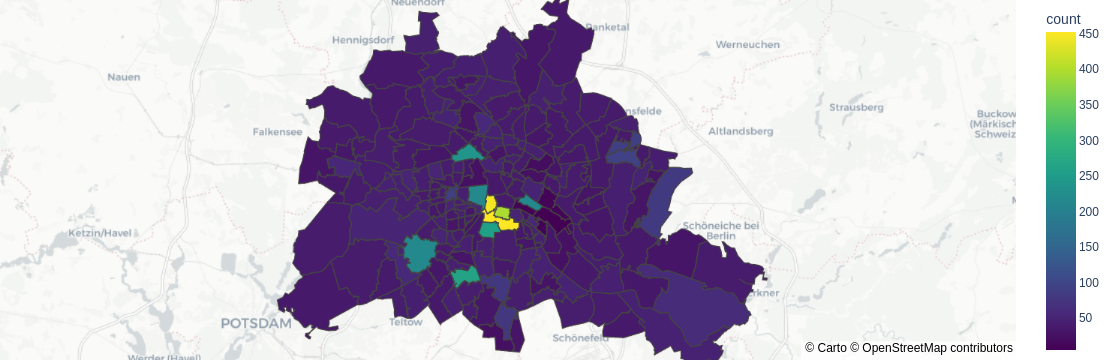

In [74]:
fig = plot_customer_density_map(gdf)

In [69]:

def create_summary_stats():
    df_customer = pd.read_csv(DATA_PATH))
    gender_counts = df_customer.groupby(["PLZ", "Geschlecht"]).size().unstack(fill_value=0)
    # Altersstatistik pro PLZ
    age_stats = df_customer.groupby("PLZ")["Alter"].agg(['count', 'mean'])
    # Beide Tabellen zusammenführen
    plz_summary = gender_counts.join(age_stats)
    return(plz_summary)


def prepare_customer_plz_map(df_customer):

    df_plz =  pd.read_csv("../data/plz_coords.csv")
    df_plz_unique = df_plz.drop_duplicates(subset="plz")
    gdf = gpd.read_file("berlin_plz_shapefile/plz.shp")
    gdf['plz'] = gdf['plz'].astype(int)


    df = pd.merge(df_customer, df_plz_unique.loc[:,["name", "plz","lat", "lon"]], left_on="PLZ", right_on="plz", how="left")

    gdf_merged = gdf.merge(df, left_on='plz', right_on='plz', how='left')
    gdf_plot = gdf_merged[gdf_merged['count'].notna()]
    gdf_plot['count'] = gdf_plot['count'].astype(float)
    gdf_plot = gdf_plot.to_crs(epsg=4326)
    return(gdf_plot)

In [71]:
def create_summary_stats():
    df_customer = pd.read_csv("../data/customers.csv")
    gender_counts = df_customer.groupby(["PLZ", "Geschlecht"]).size().unstack(fill_value=0)
    # Altersstatistik pro PLZ
    age_stats = df_customer.groupby("PLZ")["Alter"].agg(['count', 'mean'])
    # Beide Tabellen zusammenführen
    plz_summary = gender_counts.join(age_stats)
    return(plz_summary)

In [60]:
def plot_customer_density_map(gdf):
    # Choroplethenkarte mit Mapbox
    fig = px.choropleth_mapbox(
        gdf,
        geojson=gdf.geometry,
        locations=gdf.index,  # eindeutiger Index für jedes Feature
        color="count",               # Anzahl der Besucher
        hover_name="name",
        hover_data=["plz","count","mean"],
        color_continuous_scale="Viridis",
        mapbox_style="carto-positron",
        zoom=9,
        center={"lat":52.52, "lon":13.405},
    )
    
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()
    return(fig)

In [12]:
import requests
import zipfile
import io

# URL zum Shapefile (Beispiel: Berlin PLZ)
url = "https://tsb-opendata.s3.eu-central-1.amazonaws.com/plz/plz.shp.zip"

# Datei herunterladen
response = requests.get(url)
response.raise_for_status()

# ZIP entpacken
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall()  # entpackt in das aktuelle Verzeichnis
